In [29]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import pdist, squareform

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
data_url = "https://docs.google.com/spreadsheets/d/198EG3tckqzD1uOKSYxAY62i5v_0LIZQMgzaIae6u1vo/export?format=csv"
zillow = pd.read_csv(data_url)

# Drop columns with higher than 20% missing values
drop = zillow.columns[zillow.isna().mean() > 0.2]
zillow = zillow.drop(columns=drop)

# Drop remaining missing values
zillow = zillow.dropna()

# Manually selected features to use
keep_cols = [
    # How much
    "taxamount",
    # How big
    "garagetotalsqft",
    "lotsizesquarefeet",
    "numberofstories",
    #     "poolcnt",  # dropped because 0 variance
    "roomcnt",
]

zillow = zillow[keep_cols]
# zillow = zillow.sample(1500, random_state=1337)

<IPython.core.display.Javascript object>

In [4]:
scaler = StandardScaler()
scaled = scaler.fit_transform(zillow)

<IPython.core.display.Javascript object>

In [5]:
sim_mat = -squareform(pdist(scaled))
sim_mat.min() - 1

-43.07119774057715

<IPython.core.display.Javascript object>

In [6]:
clst = AffinityPropagation(affinity="precomputed", damping=0.99, verbose=1)
clst.fit(sim_mat)

Converged after 15 iterations.


AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
                    damping=0.99, max_iter=200, preference=None, verbose=1)

<IPython.core.display.Javascript object>

In [21]:
cluster_df = zillow.copy()
cluster_df["label"] = clst.labels_
cluster_df["label"] = "Cluster " + cluster_df["label"].astype(str)

<IPython.core.display.Javascript object>

In [8]:
cluster_sizes = cluster_df["label"].value_counts().reset_index()
cluster_sizes.columns = ["label", "count"]

<IPython.core.display.Javascript object>

In [19]:
exemplar_idxs = clst.cluster_centers_indices_
exemplars = cluster_df.iloc[exemplar_idxs, :]

exemplars = pd.merge(exemplars, cluster_sizes, on="label")

# Threshold to be displayed
thresh = 100
display_exemplars = exemplars[exemplars["count"] >= thresh]

large_cluster_labels = display_exemplars["label"]

display_exemplars.sort_values("label").style.background_gradient()

,taxamount,garagetotalsqft,lotsizesquarefeet,numberofstories,roomcnt,label,count
16,34143.8,1269,95242,2,11,Cluster 16,218
20,24461.6,604,87377,1,8,Cluster 20,672
29,12028.5,730,28448,2,10,Cluster 29,2704
36,6704.42,562,12403,2,8,Cluster 36,7994
8,18849.7,671,87556,1,11,Cluster 8,570


<IPython.core.display.Javascript object>

In [20]:
large_cluster_df = cluster_df[cluster_df["label"].isin(large_cluster_labels)]
mean_cluster_df = large_cluster_df.groupby("label").mean()
mean_cluster_df.sort_values("label").style.background_gradient()

,taxamount,garagetotalsqft,lotsizesquarefeet,numberofstories,roomcnt
label,,,,,
Cluster 16,29520.6,1143.89,83048.7,1.92661,11.055
Cluster 20,13773.3,668.388,53410.8,1.03571,7.35119
Cluster 29,12940.9,741.172,29465.3,1.99778,9.95636
Cluster 36,5799.89,531.932,13435.6,1.61659,7.54228
Cluster 8,12330,743.888,49622.7,1.02281,9.66316


<IPython.core.display.Javascript object>

In [11]:
scaled_exemplars = pd.DataFrame(scaled[exemplar_idxs, :], columns=zillow.columns)
scaled_exemplars.std()

taxamount            6.906484
garagetotalsqft      5.916120
lotsizesquarefeet    7.957650
numberofstories      0.944576
roomcnt              1.972318
dtype: float64

<IPython.core.display.Javascript object>

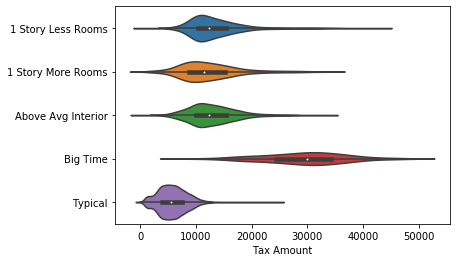

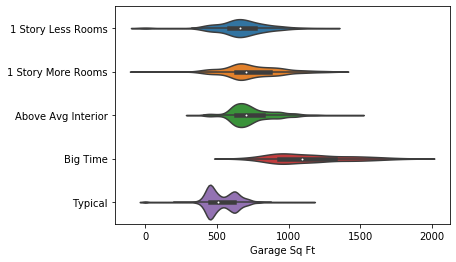

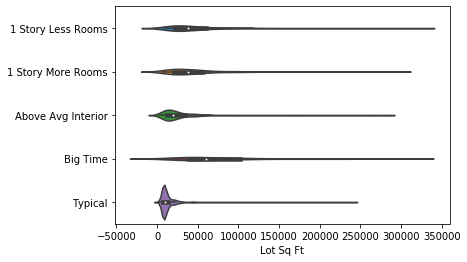

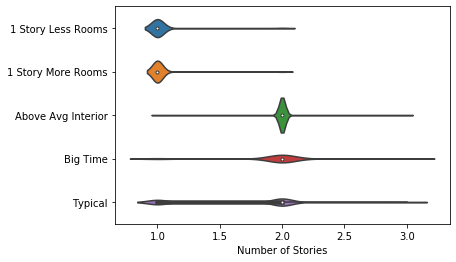

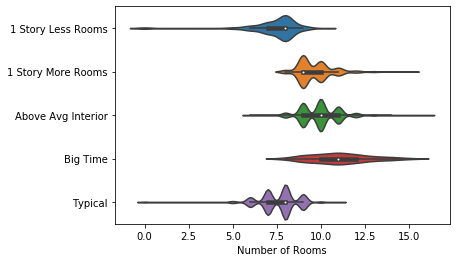

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
# Distplot per feature
# Colored by label
plot_columns = {
    "taxamount": "Tax Amount",
    "garagetotalsqft": "Garage Sq Ft",
    "lotsizesquarefeet": "Lot Sq Ft",
    "numberofstories": "Number of Stories",
    "roomcnt": "Number of Rooms",
}
labels = {
    "Cluster 36": "Typical",
    "Cluster 8": "1 Story More Rooms",
    "Cluster 20": "1 Story Less Rooms",
    "Cluster 29": "Above Avg Interior",
    "Cluster 16": "Big Time",
}

plot_cluster_df = large_cluster_df.copy()
plot_cluster_df["label"] = plot_cluster_df["label"].replace(labels)

for c in plot_columns.keys():
    plot_df = plot_cluster_df[["label", c]]
    plot_df = plot_df.sort_values("label")
    sns.violinplot(c, "label", data=plot_df)
    plt.ylabel("")
    plt.xlabel(plot_columns[c])
    plt.show()

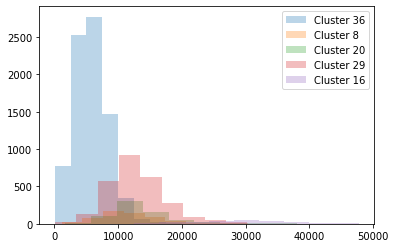

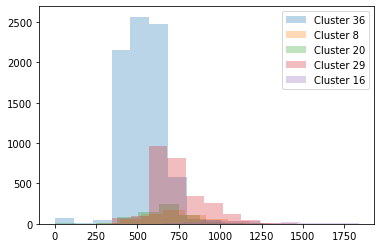

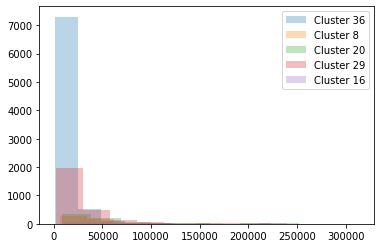

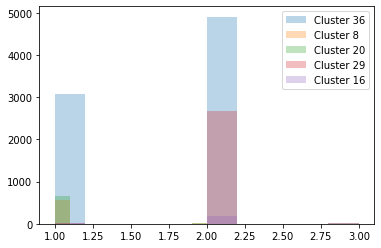

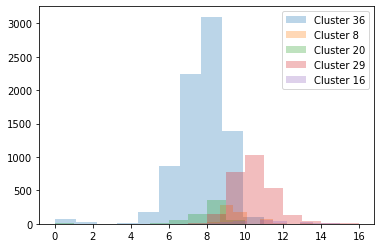

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# Distplot per feature
# Colored by label
plot_columns = {
    "taxamount": "Tax Amount",
    "garagetotalsqft": "Garage Sq Ft",
    "lotsizesquarefeet": "Lot Sq Ft",
    "numberofstories": "Number of Stories",
    "roomcnt": "Number of Rooms",
}
labels = large_cluster_df["label"].unique()

for c in plot_columns.keys():
    plot_df = large_cluster_df[["label", c]]
    for label in labels:
        plot_data = large_cluster_df.loc[cluster_df["label"] == label, c]
        plt.hist(plot_data, alpha=0.3, label=label)

    plt.legend()
    plt.show()